# Building Models. Attempt 1

## TO DO:

1. use the shape of the betas on the logistic regression to weight the previous 5 rewards
2. in addition, add an exponential decay for time (ie measured by # of trials)

In [2]:
import sys
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/shayneufeld/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
import sklearn.tree
import sys
import os
%matplotlib inline 

# Build a simple model

Where it chooses whichever port is rewarding at > 50%

In [2]:
def play(choice,pR,pL):
    outcome = np.zeros(2)
    if choice == 0: #right trial
        outcome[0] = np.random.uniform() <= pR
        outcome[1] = -1
    else:
        outcome[0] = -1
        outcome[1] = np.random.uniform() <= pL
    
    return outcome
        

def decide(last_choice,history):
    decision = -1
    
    if last_choice == 0: #right trial
        h = history[:,0]
        
        if h[h!= -1].mean() >= 0.5:
            decision = 0
        else:
            decision = 1
    
    else: #left trial
        h = history[:,1]
        
        if h[h!= -1].mean() >= 0.5:
            decision = 1
        else:
            decision = 0
    
    return decision

In [3]:
def simulate(pL=0.8,pR=0.2,block_length=50,n_trials=500):

    #initialize game
    curr_block_reward = 0
    last_choice = 0
    choices = np.zeros(n_trials)*-1
    outcomes = np.zeros((n_trials,2))
    block_num = 0

    trials = np.zeros((n_trials,6))

    for trial in range(n_trials):

        '''
        update reward probabilities
        '''
        if curr_block_reward == 50:
            pL = 1 - pL
            pR = 1 - pR
            curr_block_reward = 0
            block_num +=1

        '''
        play a trial
        '''

        if trial < 5:
            choices[trial] = decide(last_choice,outcomes[:trial,:])

        else:
            choices[trial] = decide(last_choice,outcomes[trial-5:trial,:])

        outcomes[trial,:] = play(choices[trial],pR,pL)

        '''
        store trial information
        '''

        #choice
        trials[trial,0] = choices[trial]
        #p(R)
        trials[trial,1] = pR
        #p(L)
        trials[trial,2] = pL
        #reward
        trials[trial,3] = outcomes[trial,choices[trial]]
        #switch
        if last_choice != choices[trial]:
            trials[trial,4] = 1

        #p(high)
        if pL > pR:
            if choices[trial] == 1:
                trials[trial,5] = 1
        else:
            if choices[trial] == 0:
                trials[trial,5] = 1


        '''
        update
        '''
        if outcomes[trial,choices[trial]] == 1:
            curr_block_reward += 1

        last_choice = choices[trial]
        
    '''
    convert into dataframe
    '''
    model = pd.DataFrame(data = trials,index=None,columns=['Port','pR','pL','Reward','Switch','p(high) chosen'])
        
    return model

In [4]:
model = simulate()

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [5]:
right_1 = np.where((model['Port']==0) & (model['Reward'] == 1))[0]
right_0 = np.where((model['Port']==0) & (model['Reward'] == 0))[0]

left_1 = np.where((model['Port']==1) & (model['Reward'] == 1))[0]
left_0 = np.where((model['Port']==1) & (model['Reward'] == 0))[0]

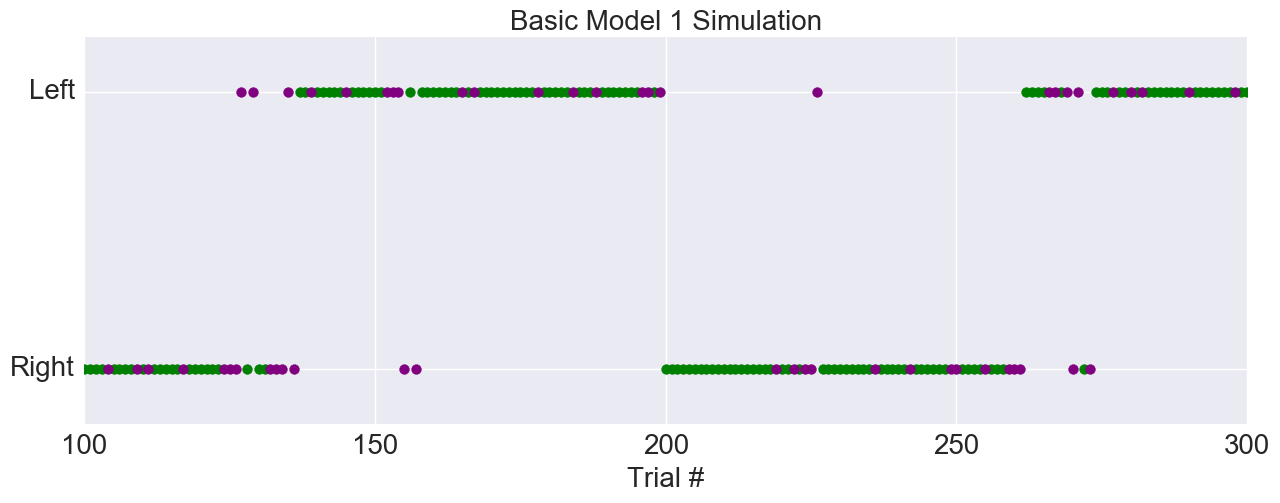

In [6]:
plt.figure(figsize=(15,5))
#plt.scatter(np.arange(n_trials),choices)
plt.scatter(right_1,np.zeros(right_1.shape[0]),color='green',s=50)
plt.scatter(right_0,np.zeros(right_0.shape[0]),color='purple',s=50)
plt.scatter(left_1,np.zeros(left_1.shape[0])+1,color='green',s=50)
plt.scatter(left_0,np.zeros(left_0.shape[0])+1,color='purple',s=50)
plt.xlim(100,300)
plt.yticks([0,1],['Right','Left'],fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Trial #',fontsize=20)
plt.title('Basic Model 1 Simulation',fontsize=20)

In [7]:
n_sims = 50

p_switch_model = np.zeros(n_sims)
for sim in range(n_sims):
    model = simulate() 
    p_switch_model[sim] = model['p(high) chosen'].mean()

/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/shayneufeld/anaconda/envs/cagrin/lib/python3.5/site-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


# Compare to data

In [8]:
data = pd.read_csv('/Users/shayneufeld/GitHub/mouse_bandit/data/processed_data/new_master_8020_df.csv',index_col=0)

In [13]:
data.head(2)

,Mouse ID,Session ID,Block Trial,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,10_trialDuration,9_Port,...,2_trialDuration,1_Port,1_Reward,1_ITI,1_trialDuration,0_ITI,Decision,Switch,Higher p port,Reward
0,dumble,70716,11.0,10.0,-1.0,1.0,1.0,1.801,0.439,1.0,...,0.325,1.0,0.0,2.133,0.482,1.411,1.0,0.0,1.0,0.0
1,dumble,70716,12.0,10.0,-2.0,1.0,1.0,1.828,0.353,1.0,...,0.482,1.0,0.0,1.411,0.435,2.169,0.0,1.0,0.0,0.0


([<matplotlib.axis.XTick at 0x112263978>,
 <a list of 2 Text xticklabel objects>)

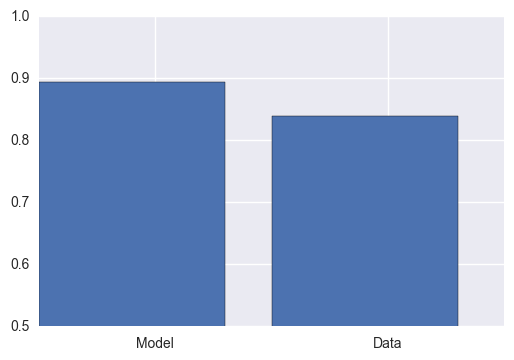

In [17]:
plt.bar([1,2],[p_switch_model.mean(),data['Higher p port'].mean()])
plt.ylim(0.5,1)
plt.xticks([1.5,2.5],['Model','Data'])

In [18]:
p_switch_model.mean()

0.89416000000000007

In [19]:
p_switch_model.std()

0.016698934097720143

In [20]:
data['Higher p port'].mean()

0.83868974042027189

(0, 10)

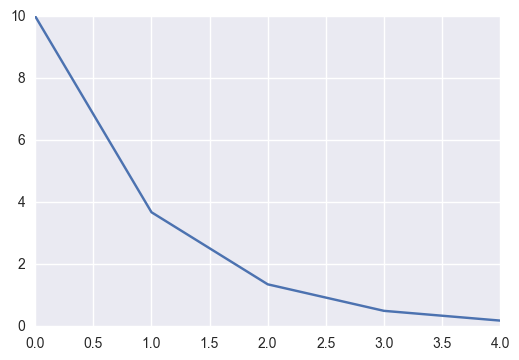

In [17]:
x = np.arange(5)

y = np.exp(-1*x)*10

plt.plot(x,y)
plt.ylim(0,10)